# Repairing images using tiles and symmetry

In [1]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

import pandas as pd

import os
import json
from pathlib import Path
from tqdm.notebook import tqdm
import inspect

import matplotlib.pyplot as plt
from matplotlib import colors
from skimage import measure

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

training_tasks = sorted(os.listdir(training_path))
evaluation_tasks = sorted(os.listdir(evaluation_path))
test_tasks = sorted(os.listdir(test_path))

In [3]:
# from: https://www.kaggle.com/boliu0/visualizing-all-task-pairs-with-gridlines

cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

def plot_one(ax, i,train_or_test,input_or_output):
   
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+input_or_output)
    

def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(axs[0,i],i,'train','input')
        plot_one(axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(axs[0],0,'test','input')
        plot_one(axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(axs[0,i],i,'test','input')
            plot_one(axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show()

In [4]:
def in_out_diff(t_in, t_out):
    x_in, y_in = t_in.shape
    x_out, y_out = t_out.shape
    diff = np.zeros((max(x_in, x_out), max(y_in, y_out)))
    diff[:x_in, :y_in] -= t_in
    diff[:x_out, :y_out] += t_out
    return diff

In [5]:
def check_symmetric(a):
    try:
        sym = 1
        if np.array_equal(a, a.T):
            sym *= 2 #Check main diagonal symmetric (top left to bottom right)
        if np.array_equal(a, np.flip(a).T):
            sym *= 3 #Check antidiagonal symmetric (top right to bottom left)
        if np.array_equal(a, np.flipud(a)):
            sym *= 5 # Check horizontal symmetric of array
        if np.array_equal(a, np.fliplr(a)):
            sym *= 7 # Check vertical symmetric of array
        return sym
    except:
        return 0

In [6]:
def call_pred_train(t_in, t_out, pred_func):
    feat = {}
    feat['s_out'] = t_out.shape
    diff = in_out_diff(t_in,t_out)
    feat['diff'] = diff
    feat['bg'] = t_in[diff!=0].max()
    feat['sym'] = check_symmetric(t_out)
    args = inspect.getargspec(pred_func).args
    if len(args)==1:
        return pred_func(t_in)
    elif len(args)==2:
        t_pred = pred_func(t_in,feat[args[1]])    
    elif len(args)==3:
        t_pred = pred_func(t_in,feat[args[1]],feat[args[2]])
    feat['sizeok'] = len(t_out)==len(t_pred)
    ok = False
    if feat['sizeok']:
        if len(t_out)==1:
            if t_pred==t_out:
                    ok = True
        elif (t_pred==t_out).all():
            ok = True
    return t_pred, feat, ok

In [7]:
def call_pred_test(t_in, pred_func, feat):
    args = inspect.getargspec(pred_func).args
    if len(args)==1:
        return pred_func(t_in)
    elif len(args)==2:
        t_pred = pred_func(t_in,feat[args[1]]) 
    elif len(args)==3:
        t_pred = pred_func(t_in,feat[args[1]],feat[args[2]])
    return t_pred

In [8]:
# from: https://www.kaggle.com/nagiss/manual-coding-for-the-first-10-tasks

def get_data(task_filename):
    with open(task_filename, 'r') as f:
        task = json.load(f)
    return task

num2color = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]
color2num = {c: n for n, c in enumerate(num2color)}

def check_p(task, pred_func):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(3, n, figsize=(4*n,12), dpi=50)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    fig_num = 0
    t_ok = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]).astype('uint8'), np.array(t["output"]).astype('uint8')
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        t_pred, feat, ok = call_pred_train(t_in, t_out, pred_func)        
        axs[2][fig_num].imshow(t_pred, cmap=cmap, norm=norm)
        axs[2][fig_num].set_title(f'Train-{i} pred')
        axs[2][fig_num].set_yticks(list(range(t_pred.shape[0])))
        axs[2][fig_num].set_xticks(list(range(t_pred.shape[1])))
        if (t_pred==t_out).all():t_ok+=1
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]).astype('uint8'), np.array(t["output"]).astype('uint8')
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        t_pred = call_pred_test(t_in, pred_func, feat)        
        axs[2][fig_num].imshow(t_pred, cmap=cmap, norm=norm)
        axs[2][fig_num].set_title(f'Test-{i} pred')
        axs[2][fig_num].set_yticks(list(range(t_pred.shape[0])))
        axs[2][fig_num].set_xticks(list(range(t_pred.shape[1])))
        if (t_pred==t_out).all():t_ok+=1
        fig_num += 1
    plt.show()
    return t_ok/fig_num

# Magic function

In [9]:
def patch_image(t_in,bg=0):
    try:
        t = t_in.copy()
        ty,tx=t_in.shape
        for i in range(4):
            m = (t==bg)
            t -= bg
            if i>1:
                if tx==ty:
                    a = np.maximum(t,t.T)
                    if (a[~m]==t[~m]).all():t=a.copy()
                    a = np.maximum(t,np.flip(t).T)
                    if (a[~m]==t[~m]).all():t=a.copy()
                else:
                    a = np.maximum(t,np.flipud(t))
                    if (a[~m]==t[~m]).all():t=a.copy()
                    a = np.maximum(t,np.fliplr(t))
                    if (a[~m]==t[~m]).all():t=a.copy()
            t += bg
            lms = measure.label(m.astype('uint8'))
            for l in range(1,lms.max()+1):
                lm = np.argwhere(lms==l)
                x_min = max(0,lm[:,1].min()-1)
                x_max = min(lm[:,1].max()+2,t.shape[0])
                y_min = max(0,lm[:,0].min()-1)
                y_max = min(lm[:,0].max()+2,t.shape[1])
                gap = t[y_min:y_max,x_min:x_max]
                if gap.size>2:
                    allst = as_strided(t, shape=(ty-gap.shape[0]+1,
                                                 tx-gap.shape[1]+1,
                                                 gap.shape[0],gap.shape[1]),
                                                 strides=t.strides+t.strides)    
                    allst = allst.reshape(-1,gap.shape[0],gap.shape[1])
                    gm = (gap!=bg)
                    for a in allst:
                        if np.count_nonzero(a==bg)==0:
                            fud = np.flipud(a)
                            flr = np.fliplr(a)
                            if (a[gm]==gap[gm]).all():
                                np.putmask(gap,~gm,a)
                                t[y_min:y_max,x_min:x_max] = gap
                                break
                            elif (fud[gm]==gap[gm]).all():
                                np.putmask(gap,~gm,fud)
                                t[y_min:y_max,x_min:x_max] = fud
                                break
                            elif (flr[gm]==gap[gm]).all():
                                np.putmask(gap,~gm,flr)
                                t[y_min:y_max,x_min:x_max] = flr
                                break          
        return t
    except:
        return t_in

## Some usage examples

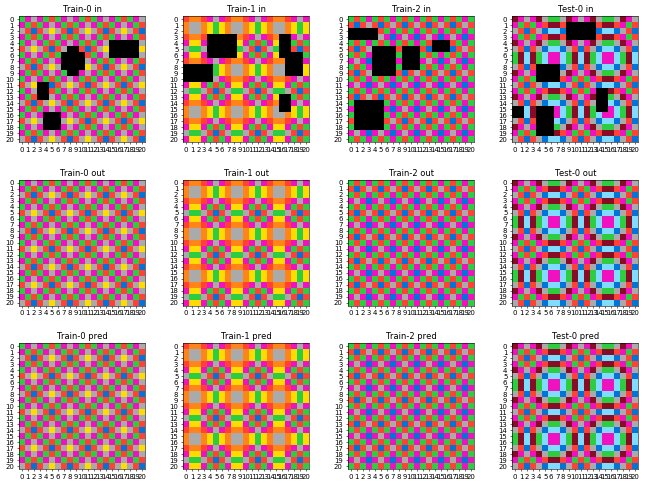

Task(16): 0c786b71.json Accuracy = 100.0 %


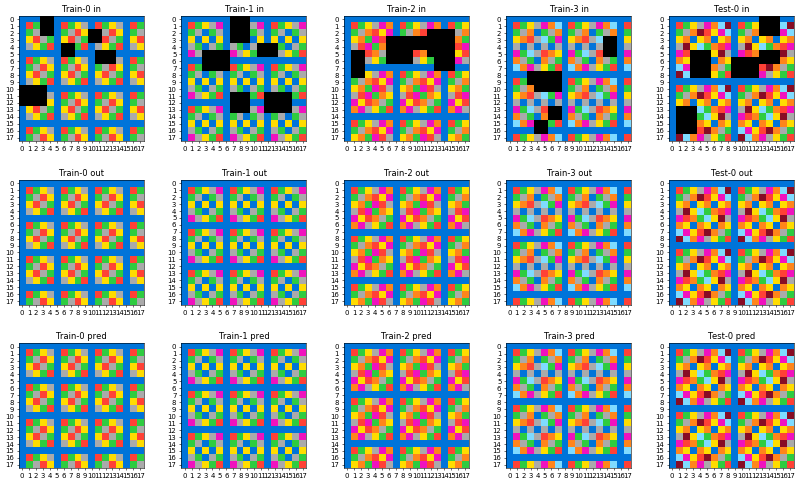

Task(60): 25094a63.json Accuracy = 100.0 %


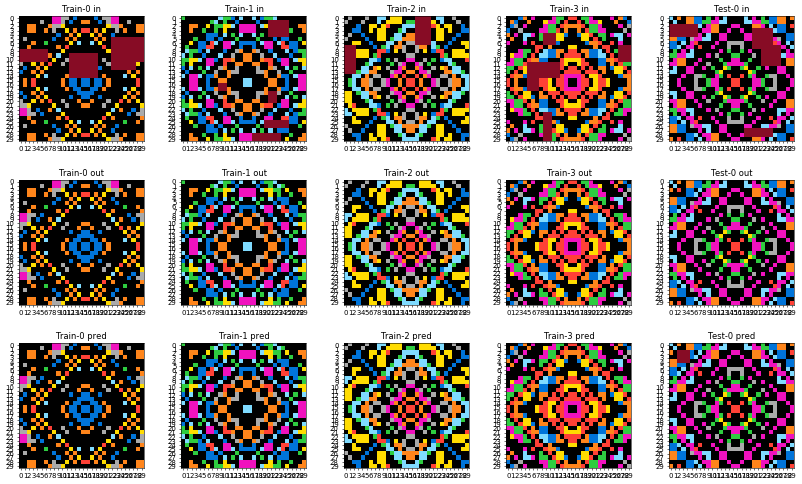

Task(73): 2c0b0aff.json Accuracy = 80.0 %


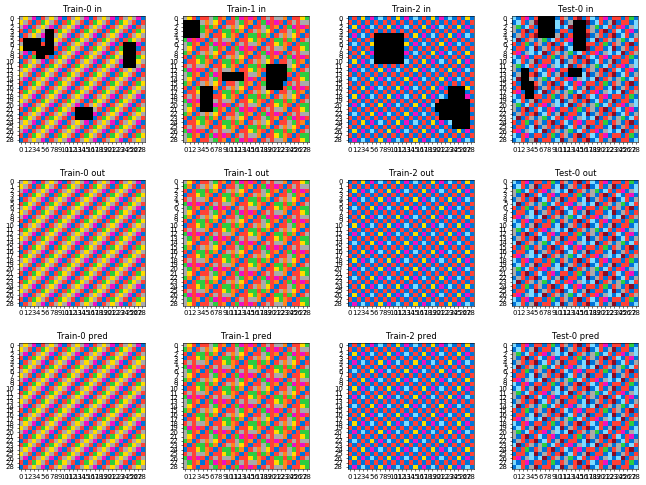

Task(109): 4852f2fa.json Accuracy = 100.0 %


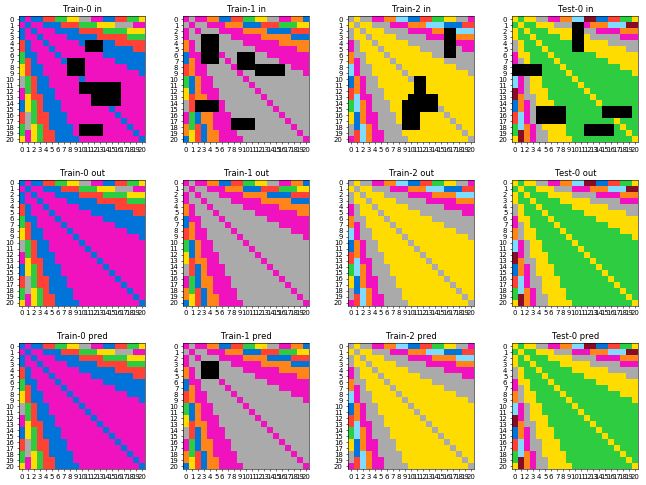

Task(174): 72207abc.json Accuracy = 75.0 %


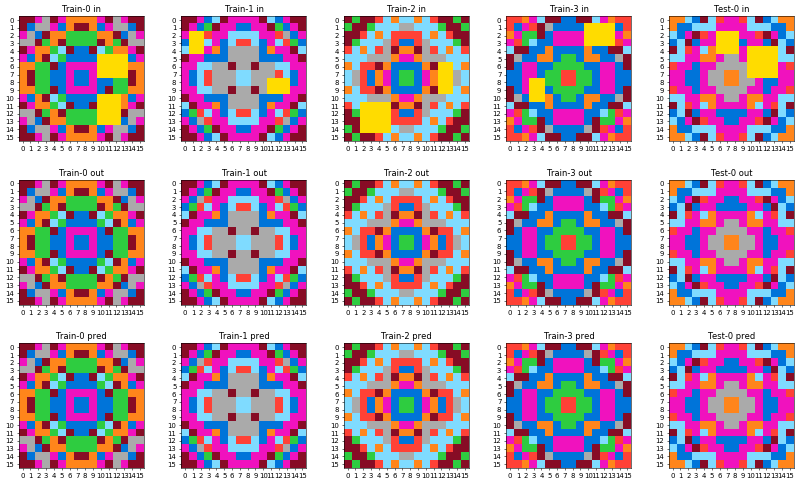

Task(286): bcb3040b.json Accuracy = 100.0 %


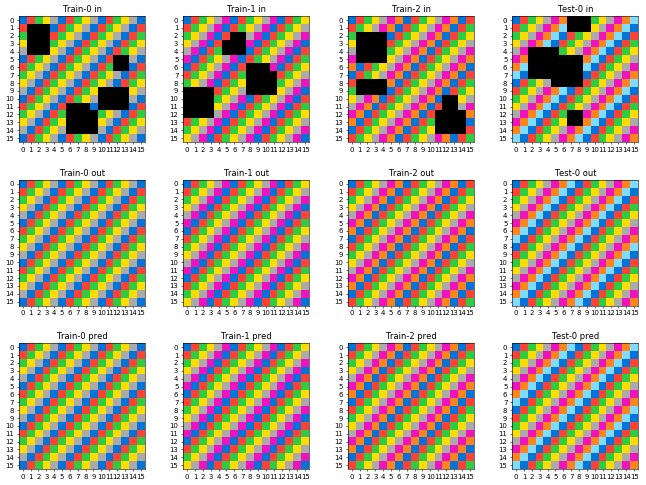

Task(304): c8b7cc0f.json Accuracy = 100.0 %


In [10]:
for t in [16, 60, 73, 109, 174, 286, 304]:
    task = get_data(str(training_path / training_tasks[t]))
    acc = check_p(task, patch_image)
    print(f'Task({t}):',evaluation_tasks[t],'Accuracy =', 100*acc,'%')

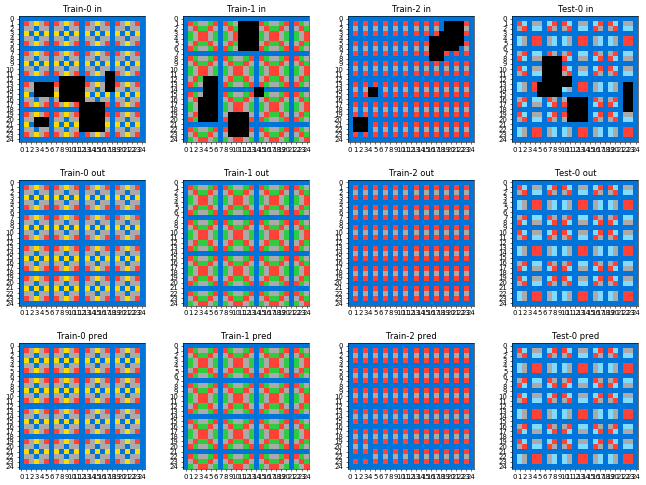

Task(48): 1d0a4b61.json Accuracy = 75.0 %


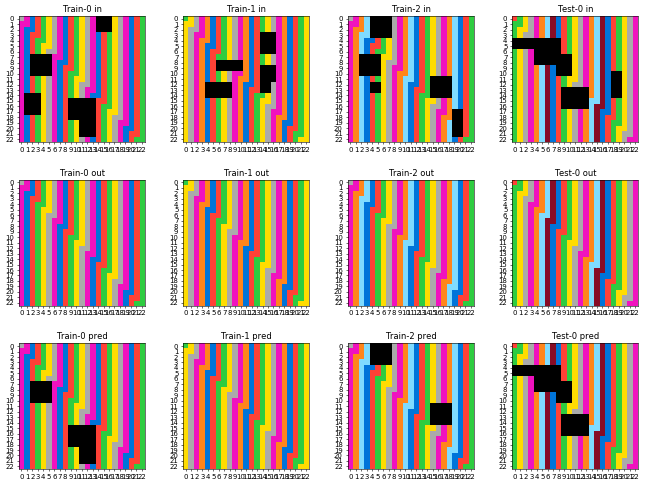

Task(52): 1e97544e.json Accuracy = 25.0 %


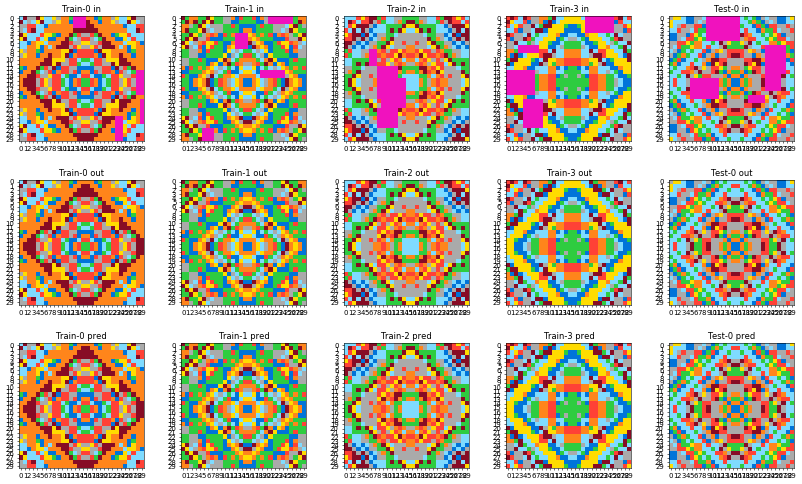

Task(107): 47996f11.json Accuracy = 100.0 %


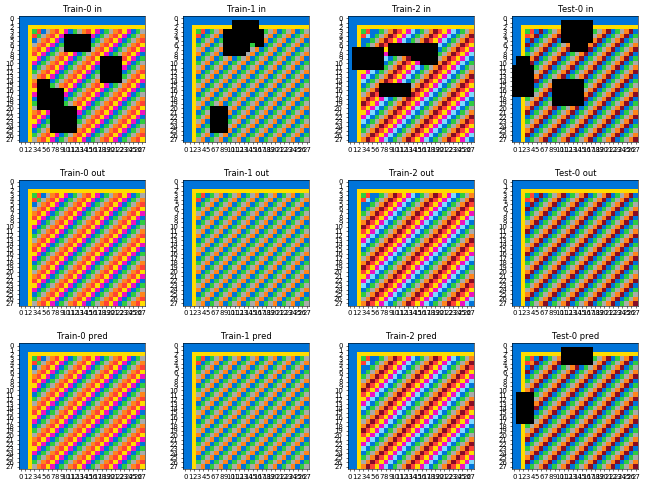

Task(111): 4aab4007.json Accuracy = 75.0 %


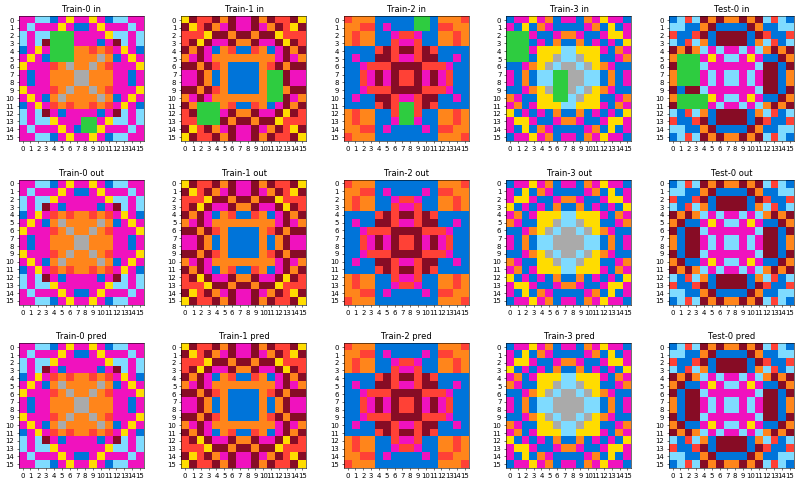

Task(216): 903d1b4a.json Accuracy = 100.0 %


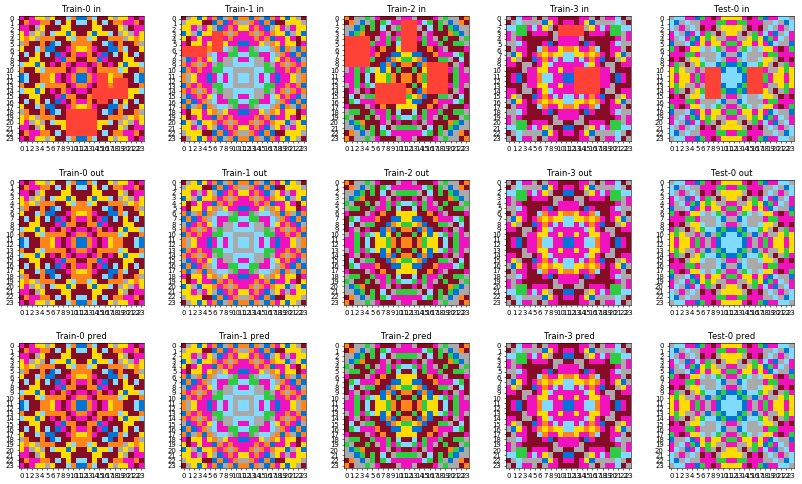

Task(219): 929ab4e9.json Accuracy = 100.0 %


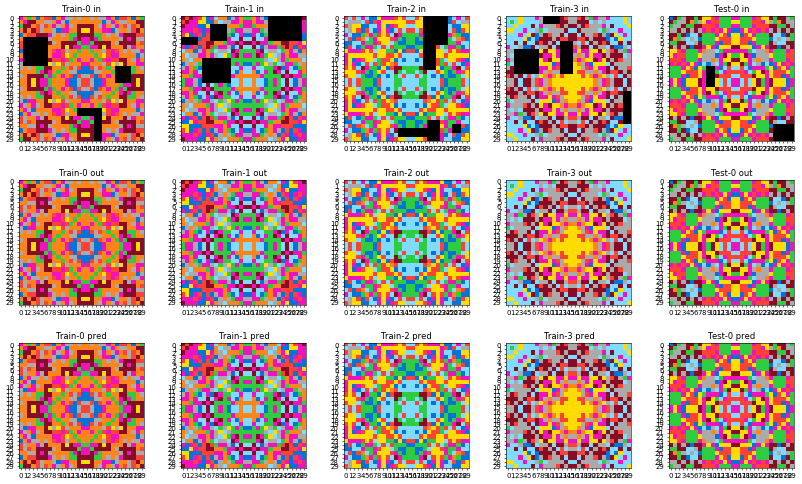

Task(232): 981571dc.json Accuracy = 100.0 %


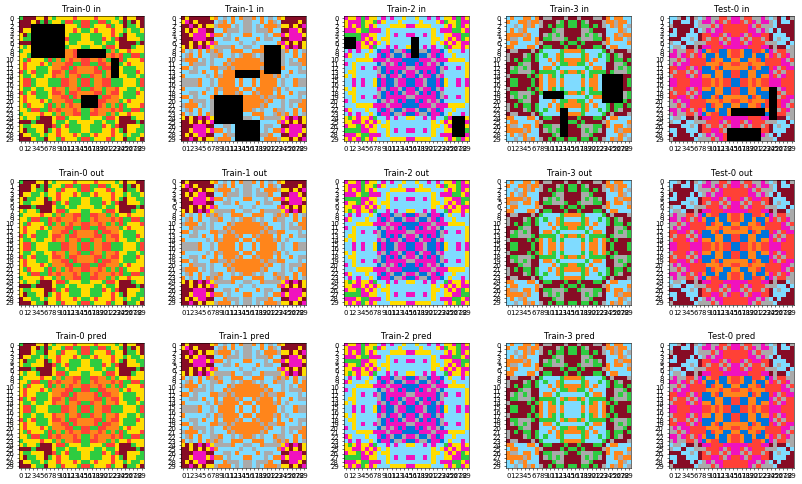

Task(266): af22c60d.json Accuracy = 100.0 %


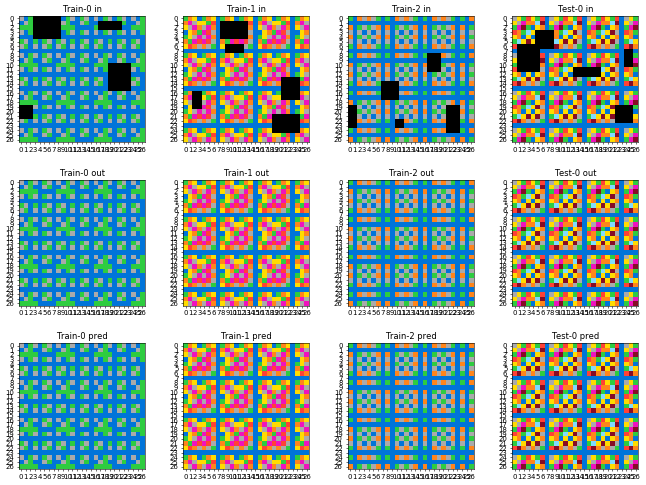

Task(300): c663677b.json Accuracy = 100.0 %


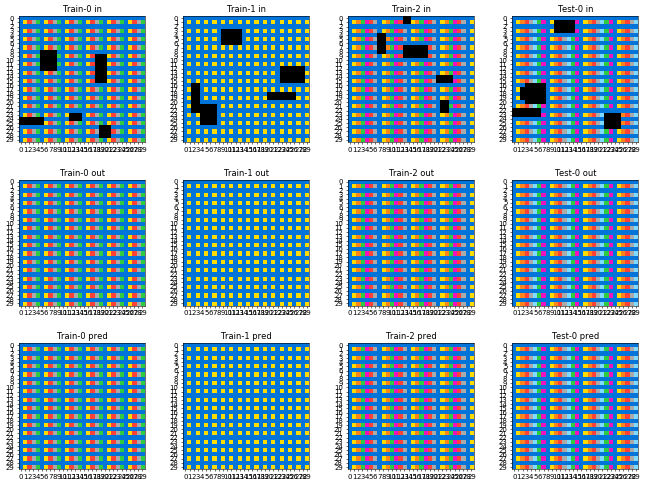

Task(308): ca8f78db.json Accuracy = 100.0 %


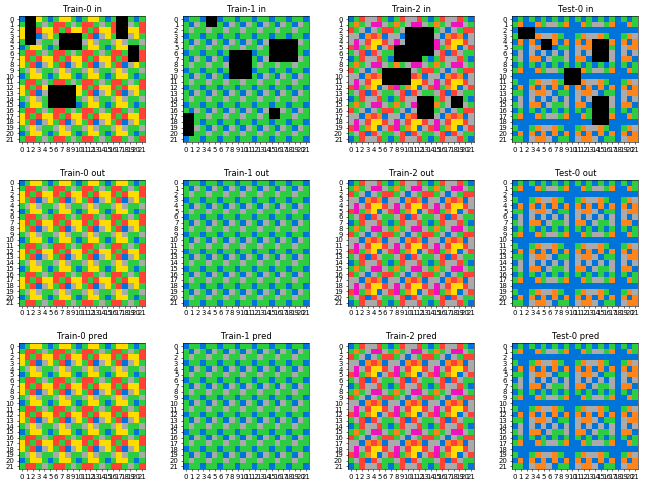

Task(365): e95e3d8e.json Accuracy = 100.0 %


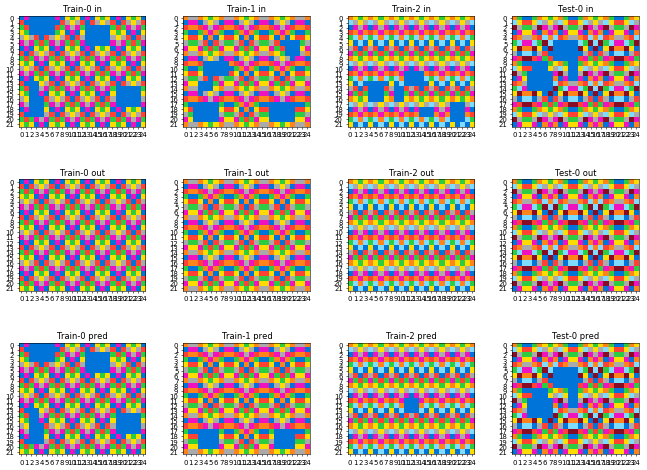

Task(371): ea959feb.json Accuracy = 0.0 %


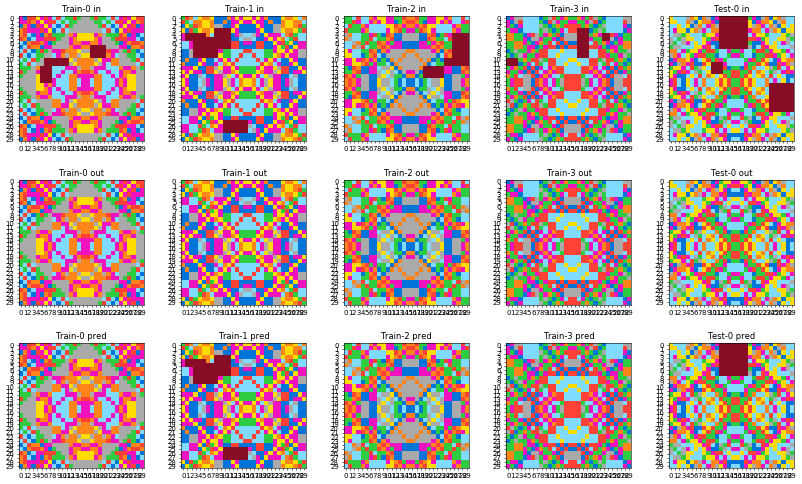

Task(391): f9d67f8b.json Accuracy = 60.0 %


In [11]:
for t in [48, 52, 107, 111, 216, 219, 232, 266, 300, 308, 365, 371, 391] :
    task = get_data(str(evaluation_path / evaluation_tasks[t]))
    acc = check_p(task, patch_image)
    print(f'Task({t}):',evaluation_tasks[t],'Accuracy =', 100*acc,'%')